In [2]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_gLV
from mimic.model_infer import *
from mimic.model_simulate import *
import pandas as pd


import numpy as np


import matplotlib.pyplot as plt


from scipy.integrate import odeint


from numpy import linalg as la

import sklearn.linear_model


from sklearn.linear_model import LinearRegression


from sklearn.linear_model import Ridge


from sklearn.linear_model import Lasso


from sklearn.linear_model import ElasticNet, ElasticNetCV


from sklearn.model_selection import RepeatedKFold


from sklearn.model_selection import cross_val_score


from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV


import sys


sys.path.append("../../")

## Simulate some time course data from the gLV


### Five species, single time course

number of species: 5
specific growth rates: [1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
perturbation matrix: 
[]


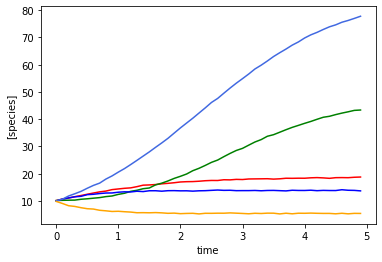

In [3]:
# In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
plot_gLV(yobs, sobs, times)

### Five species, single time course, with a perturbation

number of species: 5
specific growth rates: [1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
perturbation matrix: 
[[ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]]


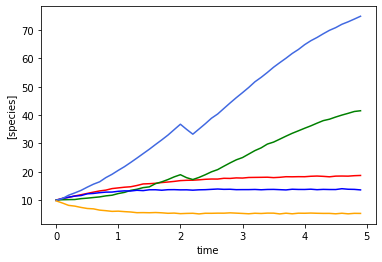

In [5]:
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct perturbation matrix
npert = 1
epsilon = np.zeros([num_species, npert])
epsilon[:, 0] = [0, -1, 0, -1, 0]

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     num_perturbations=npert,
                     M=M,
                     mu=mu,
                     epsilon=epsilon)
simulator.print()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

# perturbation information encoded in a function


def pert_fn(t):
    if 2.0 <= t < 2.2:
        return np.array([1])
    else:
        return np.array([0])


times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times,
                                               sy0=np.hstack(
                                                   (init_species, init_metabolites)),
                                               u=pert_fn)


# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
plot_gLV(yobs, sobs, times)